<a href="https://colab.research.google.com/github/H-POOJA/QuoraQuestionPairs/blob/main/21pa11's_Quora_Question_Pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [78]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [79]:
!cp /kaggle/input/quora-question-pairs/train.csv.zip .
!unzip train.csv.zip
!ls

cp: cannot stat '/kaggle/input/quora-question-pairs/train.csv.zip': No such file or directory
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
nlp_features_train.csv	train.csv      train_duplicate.txt     With_Feature.csv
sample_data		train.csv.zip  train_nonduplicate.txt


In [80]:
! pip install distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import nltk
from collections import Counter 
import distance
from matplotlib import rcParams
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import sys
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.preprocessing import normalize
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import collections
%matplotlib inline

In [82]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


# Loading Data And Getting Basics Stats

In [83]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### Here we can see that we have some missing value in question1 (1 Question) and question2 (2 Question)

<h3> 3.2.1 Distribution of data points among output classes</h3>

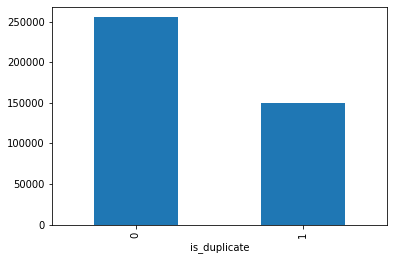

In [85]:
# Checking if we have imbalance data or not
df.groupby("is_duplicate")['id'].count().plot.bar()

### Checking if dataset is balanced or imbalanced

In [86]:
unique=len(set(list(df['qid1'])+list(df['qid2'])))
print ('Total number of  Unique Questions are: {}\n'.format(unique))

Total number of  Unique Questions are: 537933



### Percentage of Similar question and Non-Similar Question

In [87]:
print('-->> Question pairs are not Similar (is_duplicate = 0):\n     {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('-->> Question pairs are Similar (is_duplicate = 1):\n     {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

-->> Question pairs are not Similar (is_duplicate = 0):
     63.08%
-->> Question pairs are Similar (is_duplicate = 1):
     36.92%


In [88]:
qids = pd.Series(list(df['qid1']) + list(df['qid2'])) #Creating a dataframe that contains the question id of both quid1 and quid2
unique_qs = len(np.unique(qids))  #Numpy array to filter down all qniue elements
qs_morethan_onetime = np.sum(qids.value_counts() > 1)   # Counts any question that have been repeated more than one time
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#len(set(list(df['qid1'])+list(df['qid2'])))


print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,round(qs_morethan_onetime/unique_qs*100,2)))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) # Taking the frequency of all question and printing the max of them

q_vals=qids.value_counts()
print(q_vals)

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.78%)

Max number of times a single question is repeated: 157

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
416446      1
416444      1
416441      1
416439      1
537933      1
Length: 537933, dtype: int64


### Here we can see questions with qid [2559 ,30182 4044] are some the question that are repeated multiple times
### *Lets have look at those questions one by one*

In [89]:
# Looking at questions that are asked most frequently 

print(df.loc[df['qid1']==2559]['question1'].head(1).values)
print('='*50)
print(" "*50)
print(df.loc[df['qid1']==30182]['question1'].head(1).values)
print('='*50)
print(" "*50)
print(df.loc[df['qid1']==4044]['question1'].head(1).values)

['What are the best ways to lose weight?']
                                                  
['How is borderline personality disorder (BPD) treated?']
                                                  
['How can I lose weight quickly?']


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



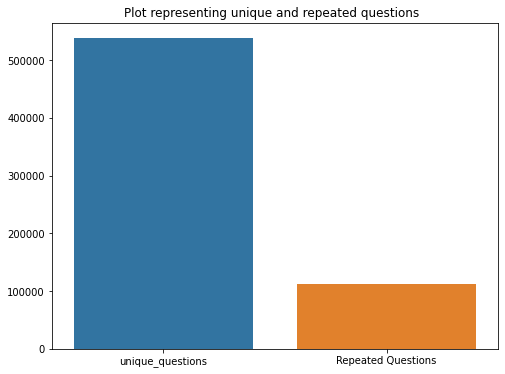

In [90]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(8, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [91]:
#checking whether there are any repeated pair of questions

duplicateRowsDF = df[df.duplicated(['qid1','qid2'])]   # Collecting all Duplicate data into a dataframe so than we can also see what duplicate value we have

print ("Number of duplicate questions : ",duplicateRowsDF.shape[0])

Number of duplicate questions :  0


## Plotting Questions based on there frequency

Maximum number of times a single question is repeated: 157



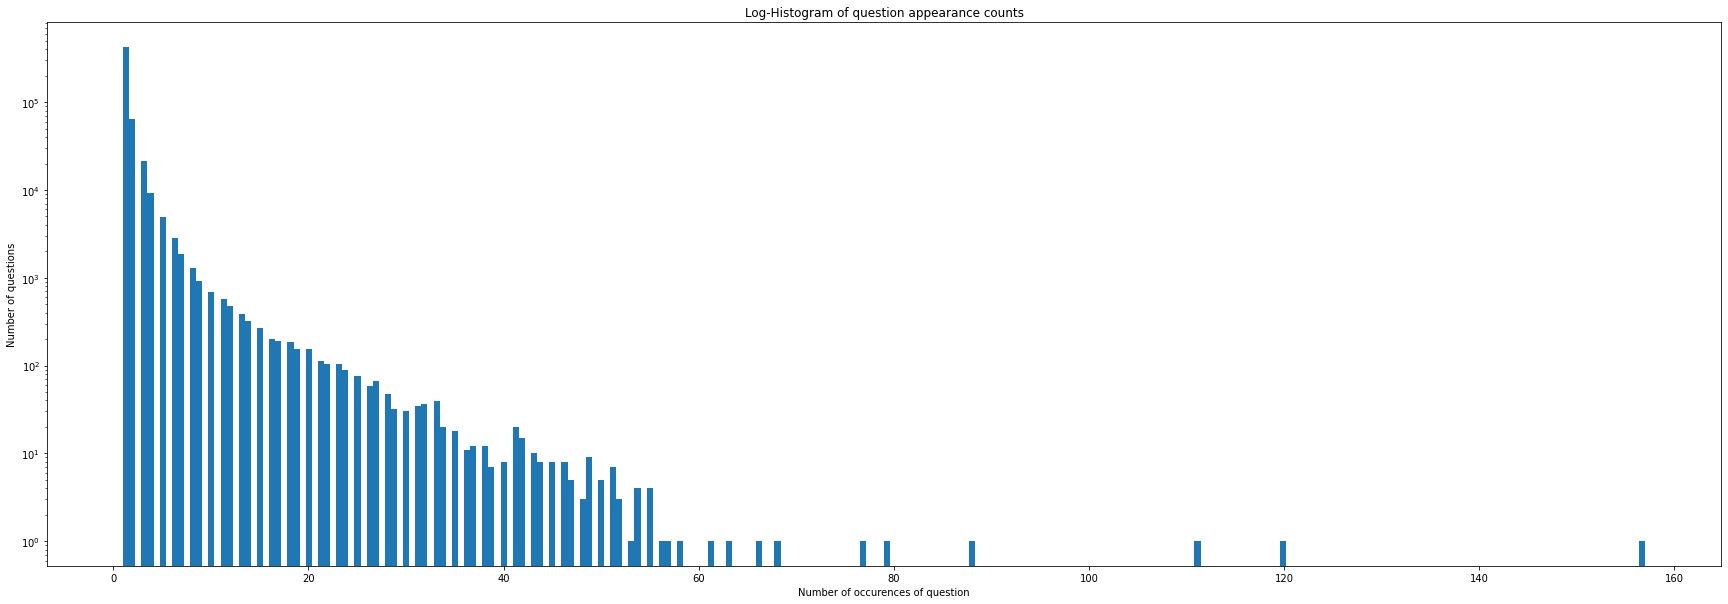

In [92]:
plt.figure(figsize=(30, 10))

plt.hist(qids.value_counts(), bins=250)

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

## Checking and Removing Null Value

In [93]:
df[df.isnull().any(1)] # Checking if any value is null in our dataset


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


### As we have very few points with NULL value then its better to remove them

In [94]:
df.dropna(inplace=True)  # Droping Null Value
df[df.isnull().any(1)] 


,id,qid1,qid2,question1,question2,is_duplicate


#  Basic Feature Extraction

In [95]:
df['Q1_Len']=df['question1'].str.len()  # Finding length of Question 1
df['Q2_Len']=df['question2'].str.len()  # Finding length of Question 2

df['Q1_Words']=df['question1'].apply(lambda row : len(row.split()))   # Finding Number of Words in Question 1
df['Q2_Words']=df['question2'].apply(lambda row : len(row.split()))   # Finding Number of Words in Question 2

# Fucntion to find the number of common words in Question 1 and Question 2

def common(row):
    '''
    We are converting both Question 1 and Question 2 to set (and also converting them to lower so that every word have same) and finding there intersection so that we can get common words
    Then we are simply finding the lenth of those common words
    '''
    return len((set(row['question1'].lower().split())).intersection(set(row['question2'].lower().split())))


# Creating New Column with Number of Common Words
df['common_Word'] = df.apply(common, axis=1)


# Total Number of Distict words in both question1 and question2

def total(row):
    '''
    Coverting them to lower form then removing extra spaces and them removing the repeted words by converting them to sets 
    Then finding Length of Both the questions and adding them to find total words in both
    '''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

# Getting total number of (unique) words in both question1 and question2
df['word_Total'] = df.apply(total, axis=1)


def word_share(row):
    '''
    Here we are finding total number of shared word and dividing by total number of words [ (A intersection B)/A+B]
    '''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))    # Finding the number of common words between question1 and question2 and dividing by total words between both of them
df['Shared_Word'] = df.apply(word_share, axis=1)


# Saving our dataframe as csv file
df.to_csv("With_Feature.csv", index=False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,Q1_Len,Q2_Len,Q1_Words,Q2_Words,common_Word,word_Total,Shared_Word
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10,23,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,20,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4,24,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2,20,0.100000


# Analysing our extracted features

## Asking Some Basic Question To Our Extracted Feature

In [96]:
print ("Minimum length of the questions in question1 : " , min(df['Q1_Words']))
print ("Minimum length of the questions in question2 : " , min(df['Q2_Words']))

print ("Number of Questions with minimum length [question1] :", df[df['Q1_Words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['Q2_Words']== 1].shape[0])

print ("Maximum length of the questions in question1 : " , max(df['Q1_Words']))
print ("Maximum length of the questions in question2 : " , max(df['Q2_Words']))

print ("Number of Questions with minimum length [question1] :", df[df['Q1_Words']>120].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['Q2_Words']> 230].shape[0])

print ("Maximum number of Common word : " , max(df['common_Word']))
print ("Maximum number of Shared Word : " , max(df['Shared_Word']))


Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 69
Number of Questions with minimum length [question2] : 25
Maximum length of the questions in question1 :  125
Maximum length of the questions in question2 :  237
Number of Questions with minimum length [question1] : 1
Number of Questions with minimum length [question2] : 13
Maximum number of Common word :  41
Maximum number of Shared Word :  0.5


## Analysing Shared Word

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



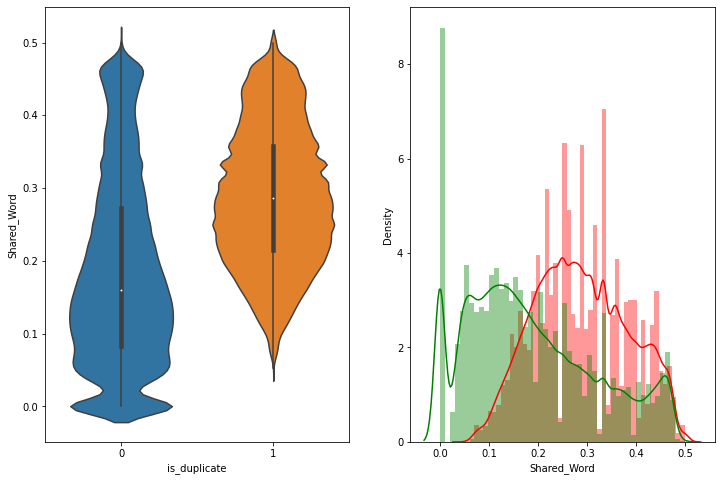

In [97]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Shared_Word', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['Shared_Word'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['Shared_Word'][0:] , label = "0" , color = 'green' )
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



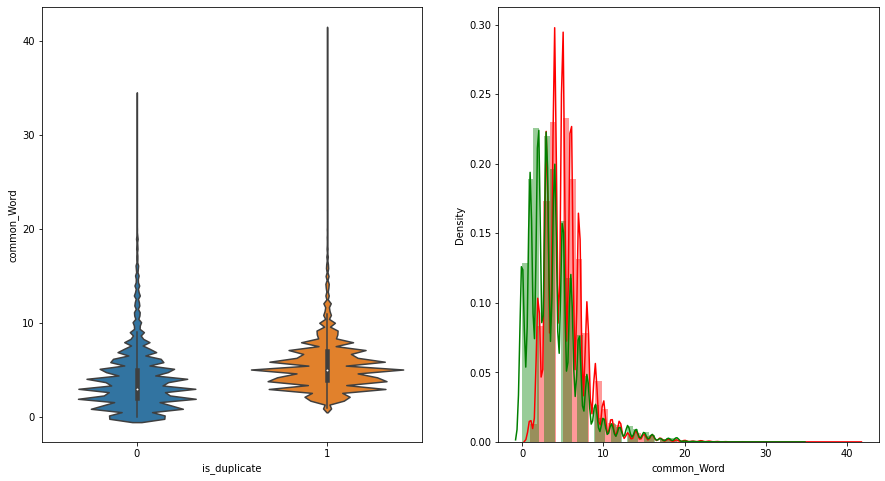

In [98]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_Word', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['common_Word'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['common_Word'][0:] , label = "0" , color = 'green' )
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



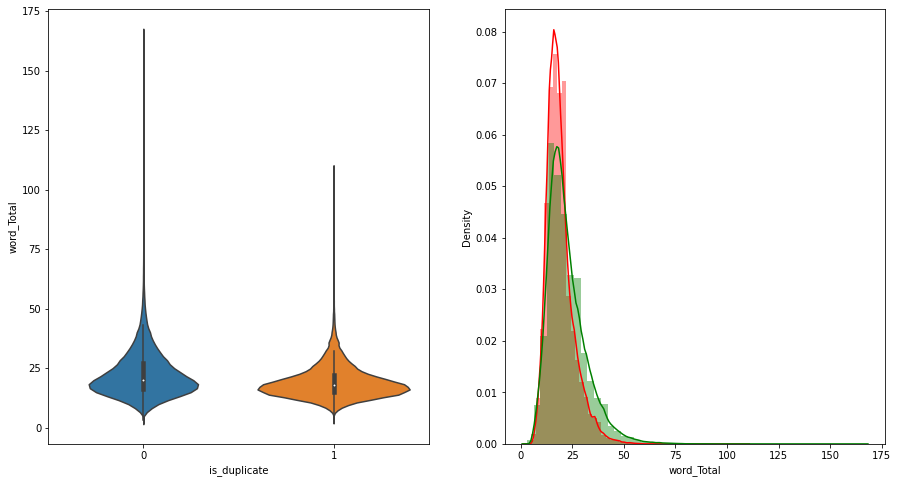

In [99]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Total', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Total'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Total'][0:] , label = "0" , color = 'green' )
plt.show()

****
# [2]Text pre-processing


### Creating our very own stopword list after removing some stop words like how,whom ,not , etc that may be useful to differentiate between questions

In [100]:
from nltk.stem import SnowballStemmer
snow=nltk.stem.SnowballStemmer('english')

# Creating custom stopwords

stopwords= set(['the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


### Simple fuction to perform stemming while removing StopWords

In [101]:
def removeStopWord(word):
  token=word.split(" ")   ## coverting string to token (list of word) \\ like ["this","is","token"]
  removestop=[snow.stem(x) for x in token if x not in stopwords]   ##removing stopwords and also doing Stemming
  removed=" ".join(removestop)  ##joing back the list into sentence
  return removed

### Replacing common words like 1000 to 1k or 1m and many other and removing special characters 

In [102]:

def preprocess(x):
    x = str(x).lower()  # Lowering all text to covert all of them to there base form
    
    # Replacing commonly use words or numbers like 1,000 to 1k and 1,000,000 to 1m and currency symbol to there respective names and many other symbols to there name
    
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " is")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("@","at")
    
    # Renaming 1000 to 1k and 1000000 to 1m (the onces which may not be seperated with commans)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    #Remove any special character like [= , ' ; "" ']
    
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    #Removing Stopwords And Doing Stemming
    x=removeStopWord(x)          
    
    return x

##  Pre-processing our Questions data (Removing Stop Words, Doing Stemming and more) 

In [103]:
# Doing Pre-processing on both question1 and question2

df['cleanQ1']=df['question1'].apply(preprocess)
df['cleanQ2']=df['question2'].apply(preprocess)

### Lets look how pre-processing changed our question text

In [104]:
print('Questions 1 without pre-processing')
print(df['question1'][2])
print()
print('Questions 1 after pre-processing')
print(df['cleanQ1'][2])
print()
print('Questions 2 without pre-processing')
print(df['question2'][2])
print()
print('Questions 2 after pre-processing')
print(df['cleanQ2'][2])


Questions 1 without pre-processing
How can I increase the speed of my internet connection while using a VPN?

Questions 1 after pre-processing
how increas speed internet connect use vpn 

Questions 2 without pre-processing
How can Internet speed be increased by hacking through DNS?

Questions 2 after pre-processing
how internet speed increas hack dns 


# Advance Feature Engineering Using NLP and Fuzzy Features

### Simple Ratio : Measurement of edit distance (Minimum number of edits required to convert one sentence to other )
### Partial Ratio : How much accuratly a part of sentence match to other sentence ("Chennai Super Kings", "Super Kings")
### Token Sort Ratio : Tokenizing the string in question, sorting the tokens alphabetically, and then joining them back into a string
### Token Set Ratio : Tokenize both strings,split the tokens into two groups of intersection and remainder. We use those sets to build up a comparison string.

### Last_Word : Checks if last word is same in both Q1 and Q2
### First_Word : Checks if First word is same in both Q1 and Q2
### Length_diff : Finds the length diffrence between Q1 and Q2
### StopWord_Ratio : Number of stopwords in both Questions
### Token_Ratio :  Number of tokens in both Questions
### Longest_Substr_ratio : Ratio of the Longest Substring that is found in between Q1 and Q2

In [105]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

df['Simple_Ratio']=df.apply(lambda x: fuzz.ratio(x['cleanQ1'],x['cleanQ2']) ,axis=1)

df['Partial_Ratio']=df.apply(lambda x: fuzz.partial_ratio(x['cleanQ1'],x['cleanQ2']) ,axis=1)

df['Token_Sort_Ratio']=df.apply(lambda x: fuzz.token_sort_ratio(x['cleanQ1'],x['cleanQ2']) ,axis=1)

df['Token_Set_Ratio']=df.apply(lambda x: fuzz.token_set_ratio(x['cleanQ1'],x['cleanQ2']) ,axis=1)



In [107]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [108]:


df['Last_Word']=df.apply(lambda x: int(x['question1'].split()[-1] == x['question2'].split()[-1]),axis=1)


df['First_Word']=df.apply(lambda x: int(x['question1'].split()[0] == x['question2'].split()[0]),axis=1)


df['Length_diff']=df.apply(lambda x: abs(len(x['question1'].split())-len(x['question2'].split())),axis=1)




In [109]:
def common_StopWord_Ratio(q1,q2):
    q1_token=q1.split() # Splitting Words to make then tokens
    q2_token=q2.split()
    
    # We are takking out all the stopwords in both the Question and finding there intersection (Common stopwords)
    q1=set([word for word in q1_token if word in stopwords])
    q2=set([word for word in q2_token if word in stopwords])
    common=q1.intersection(q2)
    ratio=len(common)/len(set(q1_token))+len(set(q2_token))
    
    return ratio

def common_Token_Ratio(q1,q2):
    q1_token=q1.split()
    q2_token=q2.split()
    # We are takking out all the token in both the Question and finding there intersection (Common tokens)
    q1=set([x for x in q1_token if x not in stopwords])
    q2=set([x for x in q2_token if x not in stopwords])
    
    common=q1.intersection(q2)
    ratio=len(common)/len(set(q1_token))+len(set(q2_token))
    
    return ratio

def get_longest_substr_ratio(a, b):
    
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return round(len(strs[0]) / (min(len(a), len(b)) + 1),5)

def common_Characters(q1,q2):
    q1="".join(q1.split())
    q2="".join(q2.split())
    c=0
    d=dict(Counter(q1))
    for i in q2:
        if i in d and d[i]!=0:
            c+=1;d[i]-=1
    return c

In [110]:
df['Common_StopWord_Ratio']= df.apply(lambda x: common_StopWord_Ratio(x["question1"], x["question2"]), axis=1)

df['common_Token_Ratio']=df.apply(lambda x: common_Token_Ratio(x["question1"], x["question2"]), axis=1)

df['get_longest_substr_ratio']=df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

df['common_Characters']=df.apply(lambda x: common_Characters(x["question1"], x["question2"]), axis=1)

In [111]:
df.head() 

,id,qid1,qid2,question1,question2,is_duplicate,Q1_Len,Q2_Len,Q1_Words,Q2_Words,...,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Last_Word,First_Word,Length_diff,Common_StopWord_Ratio,common_Token_Ratio,get_longest_substr_ratio,common_Characters
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,...,100,93,100,0,1,2,11.416667,11.416667,0.96552,46
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,...,85,65,91,0,1,5,12.125000,12.375000,0.44231,41
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,...,42,73,85,0,1,4,10.071429,10.142857,0.15000,41
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,...,42,26,31,0,0,2,9.000000,9.000000,0.03922,22
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,...,51,51,64,0,1,6,7.076923,7.076923,0.15000,30


### Removing Uncleaned Questions

In [112]:
# Deleting question1 from our data frame
del df['question1']

# Deleting question2 from our data frame
del df['question2']

# Printing dataset after deletion

df.head()

,id,qid1,qid2,is_duplicate,Q1_Len,Q2_Len,Q1_Words,Q2_Words,common_Word,word_Total,...,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Last_Word,First_Word,Length_diff,Common_StopWord_Ratio,common_Token_Ratio,get_longest_substr_ratio,common_Characters
0,0,1,2,0,66,57,14,12,10,23,...,100,93,100,0,1,2,11.416667,11.416667,0.96552,46
1,1,3,4,0,51,88,8,13,4,20,...,85,65,91,0,1,5,12.125000,12.375000,0.44231,41
2,2,5,6,0,73,59,14,10,4,24,...,42,73,85,0,1,4,10.071429,10.142857,0.15000,41
3,3,7,8,0,50,65,11,9,0,19,...,42,26,31,0,0,2,9.000000,9.000000,0.03922,22
4,4,9,10,0,76,39,13,7,2,20,...,51,51,64,0,1,6,7.076923,7.076923,0.15000,30


In [113]:
# saving our dataframe as csv
df.to_csv('nlp_features_train.csv')

## Analysing our extracted features

In [114]:
# Creating two dataframe of both duplicate and non duplicate and then extacting all the text and saving then in text file
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate['cleanQ1'], df_duplicate['cleanQ2']]).flatten()
n = np.dstack([dfp_nonduplicate["cleanQ1"], dfp_nonduplicate["cleanQ2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_duplicate.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_nonduplicate.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510048


In [115]:
# reading the text files

textDupli = open('train_duplicate.txt').read()
textNon = open('train_nonduplicate.txt').read()

## WordCloud

In [116]:
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")
  

Word Cloud for Duplicate Question pairs


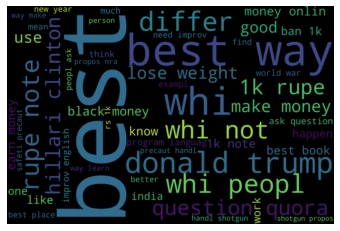

In [117]:
wc = WordCloud(width = 3000,height = 2000, background_color="black", max_words=50, stopwords=stopwords)
wc.generate(textDupli)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


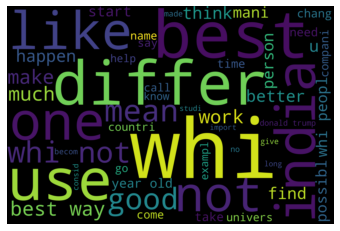

In [118]:
# Word Clouds generated from non duplicate pair question's text
wc = WordCloud(width = 3000,height = 2000, background_color="black", max_words=50, stopwords=stopwords)
wc.generate(textNon)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

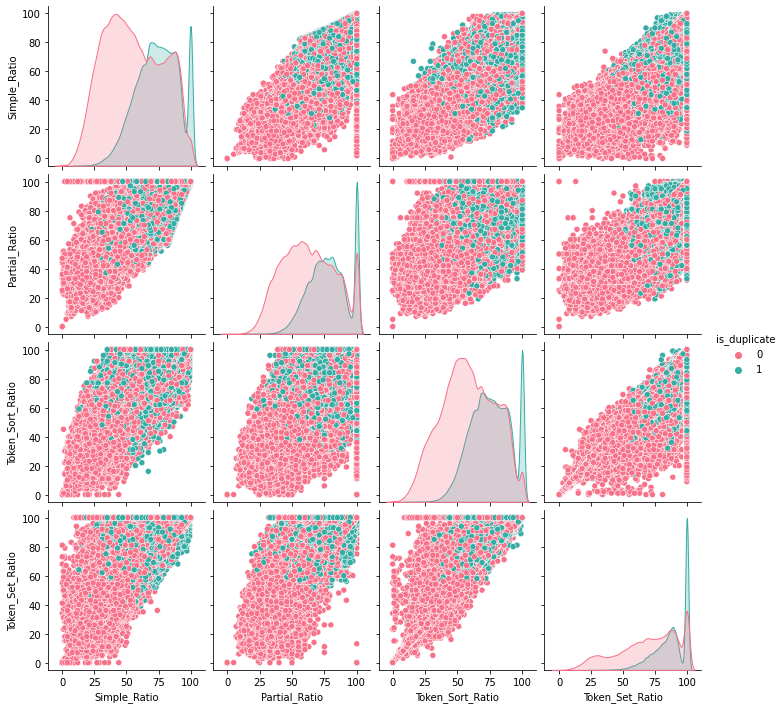

In [119]:
n = df.shape[0]
sns.pairplot(df[['Simple_Ratio', 'Partial_Ratio', 'Token_Sort_Ratio', 'Token_Set_Ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['Simple_Ratio', 'Partial_Ratio', 'Token_Sort_Ratio', 'Token_Set_Ratio'], palette="husl")
plt.show()

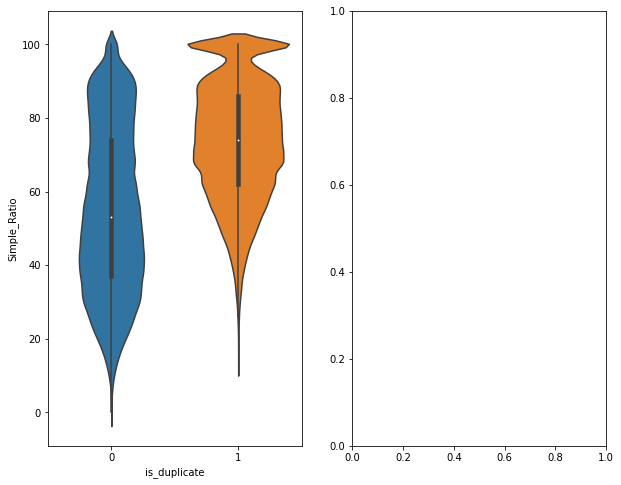

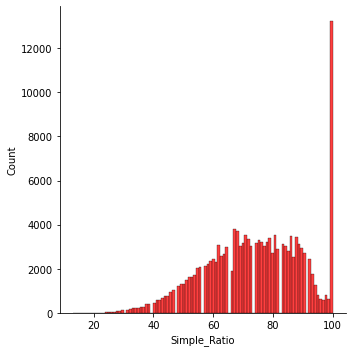

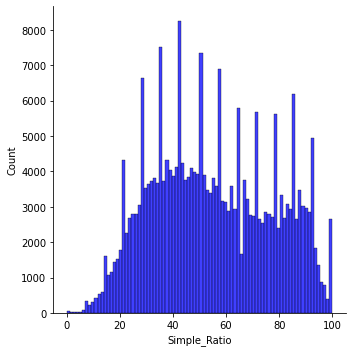

In [120]:
# Distribution of the Simple_Ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Simple_Ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.displot(df[df['is_duplicate'] == 1.0]['Simple_Ratio'][0:] , label = "1", color = 'red')
sns.displot(df[df['is_duplicate'] == 0.0]['Simple_Ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

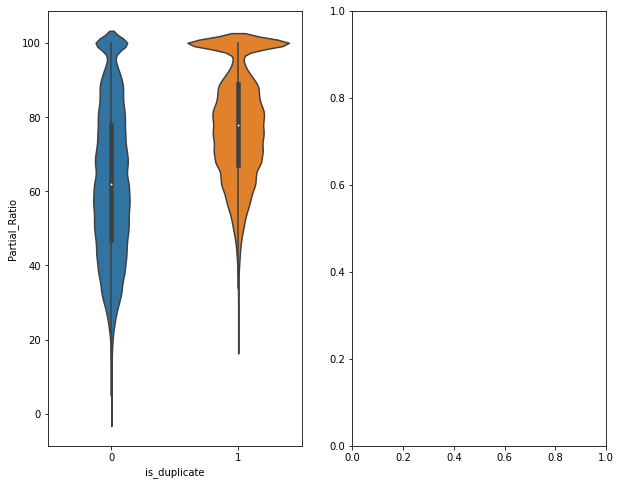

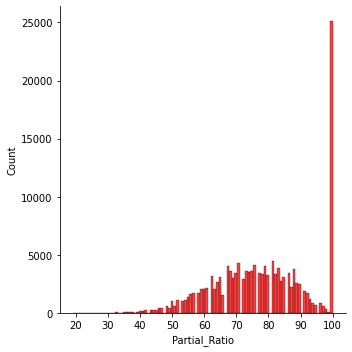

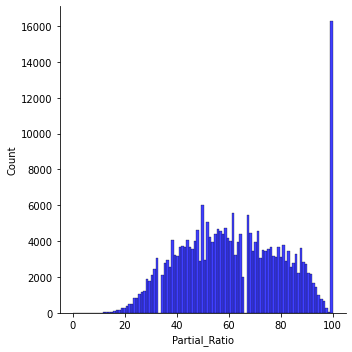

In [121]:
# Distribution of the Partial_Ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Partial_Ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.displot(df[df['is_duplicate'] == 1.0]['Partial_Ratio'][0:] , label = "1", color = 'red')
sns.displot(df[df['is_duplicate'] == 0.0]['Partial_Ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

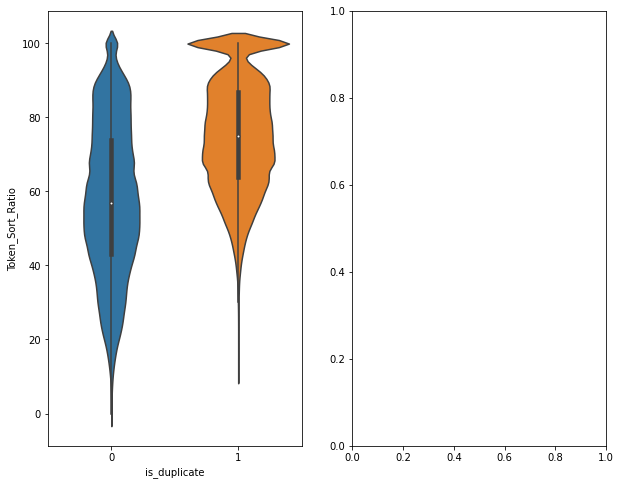

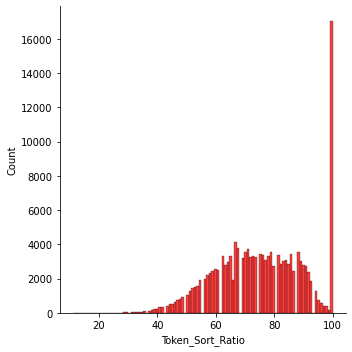

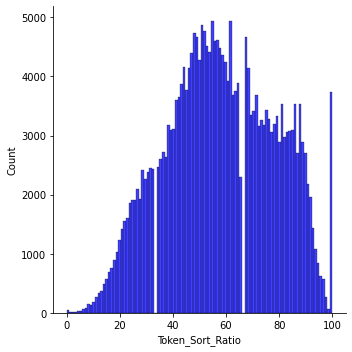

In [122]:
# Distribution of the Token_Sort_Ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Token_Sort_Ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.displot(df[df['is_duplicate'] == 1.0]['Token_Sort_Ratio'][0:] , label = "1", color = 'red')
sns.displot(df[df['is_duplicate'] == 0.0]['Token_Sort_Ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

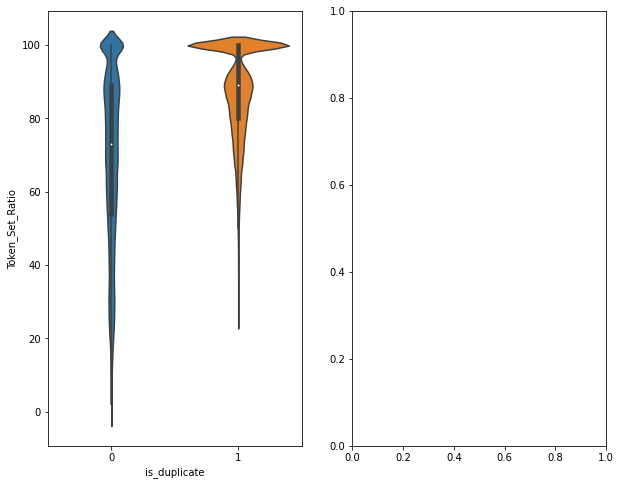

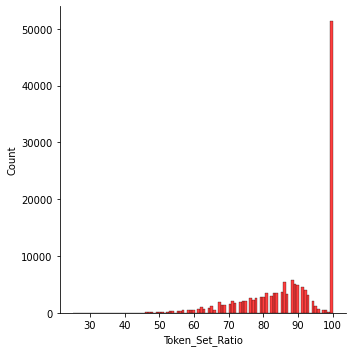

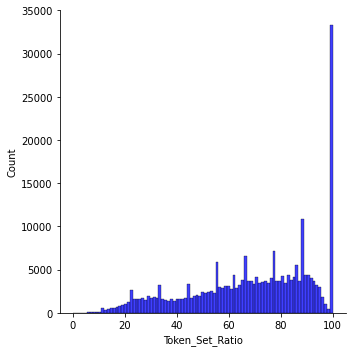

In [123]:
# Distribution of the Token_Set_Ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Token_Set_Ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.displot(df[df['is_duplicate'] == 1.0]['Token_Set_Ratio'][0:] , label = "1", color = 'red')
sns.displot(df[df['is_duplicate'] == 0.0]['Token_Set_Ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

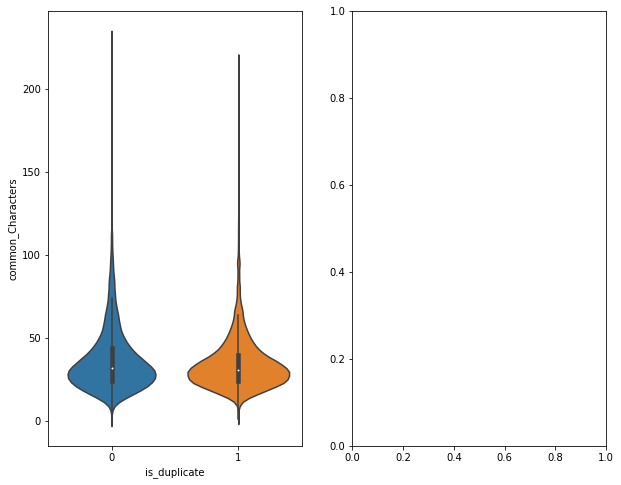

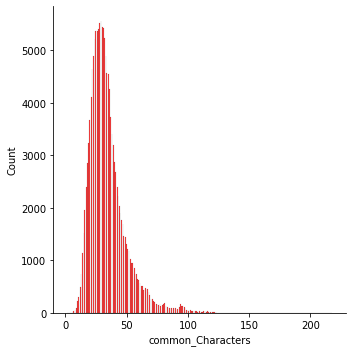

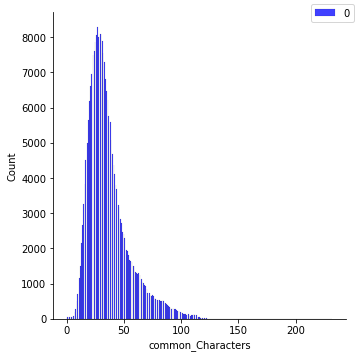

In [125]:
# Distribution of the Common_Characters
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_Characters', data = df[0:] , )

plt.subplot(1,2,2)
sns.displot(df[df['is_duplicate'] == 1.0]['common_Characters'][0:] , label = "1", color = 'red')
sns.displot(df[df['is_duplicate'] == 0.0]['common_Characters'][0:] , label = "0" , color = 'blue' )
plt.figlegend()
plt.show()

**Common_Characters does not seem to have much impact**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



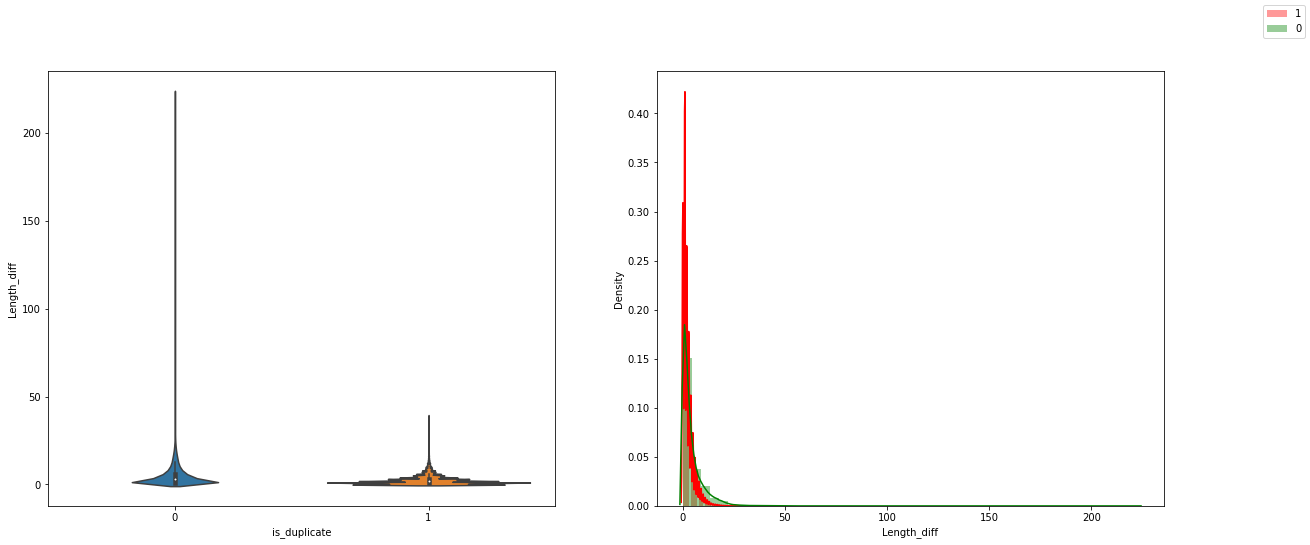

In [126]:
# Distribution of the Length_diff
plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Length_diff', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['Length_diff'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['Length_diff'][0:] , label = "0" , color = 'green' )
plt.figlegend()

plt.show()

In [127]:
df.columns

Index(['id', 'qid1', 'qid2', 'is_duplicate', 'Q1_Len', 'Q2_Len', 'Q1_Words',
       'Q2_Words', 'common_Word', 'word_Total', 'Shared_Word', 'cleanQ1',
       'cleanQ2', 'Simple_Ratio', 'Partial_Ratio', 'Token_Sort_Ratio',
       'Token_Set_Ratio', 'Last_Word', 'First_Word', 'Length_diff',
       'Common_StopWord_Ratio', 'common_Token_Ratio',
       'get_longest_substr_ratio', 'common_Characters'],
      dtype='object')

In [131]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['Simple_Ratio', 'Partial_Ratio', 'Token_Sort_Ratio', 'Token_Set_Ratio','Q1_Len', 'Q2_Len', 'Q1_Words','Q2_Words', 'common_Word', 'word_Total', 'Shared_Word','Last_Word', 'First_Word', 'Length_diff','Common_StopWord_Ratio', 'common_Token_Ratio', 'get_longest_substr_ratio' ]])
y = dfp_subsampled['is_duplicate'].values

In [132]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.813s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.100735
[t-SNE] Computed conditional probabilities in 0.285s
[t-SNE] Iteration 50: error = 81.4644012, gradient norm = 0.0626297 (50 iterations in 2.649s)
[t-SNE] Iteration 100: error = 71.6195679, gradient norm = 0.0109378 (50 iterations in 1.720s)
[t-SNE] Iteration 150: error = 70.2359467, gradient norm = 0.0061146 (50 iterations in 1.530s)
[t-SNE] Iteration 200: error = 69.6729584, gradient norm = 0.0038218 (50 iterations in 1.476s)
[t-SNE] Iteration 250: error = 69.3478622, gradient norm = 0.0032765

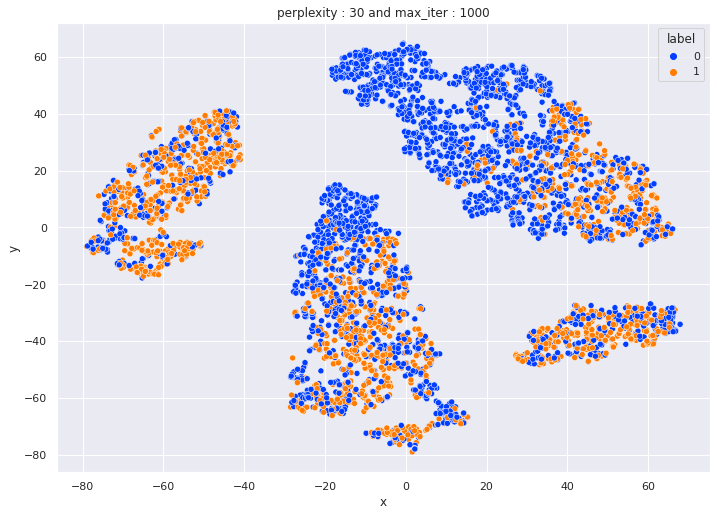

In [133]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

palette = sns.color_palette("bright", 2)
# draw the plot in appropriate place in the grid
sns.scatterplot(data=df, x='x', y='y', hue='label',legend='full', palette=palette)
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [134]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.809s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.100735
[t-SNE] Computed conditional probabilities in 0.264s
[t-SNE] Iteration 50: error = 81.5973663, gradient norm = 0.0337661 (50 iterations in 11.812s)
[t-SNE] Iteration 100: error = 70.8700256, gradient norm = 0.0030905 (50 iterations in 4.505s)
[t-SNE] Iteration 150: error = 69.8404999, gradient norm = 0.0016472 (50 iterations in 3.522s)
[t-SNE] Iteration 200: error = 69.4312286, gradient norm = 0.0010721 (50 iterations in 3.494s)
[t-SNE] Iteration 250: error = 69.1757355, gradient norm = 0.001043

In [135]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# Featurizing text data

In [137]:
!pip install spacy
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [138]:
df=pd.read_csv('./nlp_features_train.csv')
df=df[['cleanQ1','cleanQ2','is_duplicate']]
df['cleanQ1'] = df['cleanQ1'].apply(lambda x: str(x))
df['cleanQ2'] = df['cleanQ2'].apply(lambda x: str(x))
df.head()

,cleanQ1,cleanQ2,is_duplicate
0,what step step guid invest share market india,what step step guid invest share market,0
1,what stori kohinoor koh noor diamond,what would happen indian govern stole kohinoor...,0
2,how increas speed internet connect use vpn,how internet speed increas hack dns,0
3,whi mental lone how solv,find remaind when math 23 24 math divid 2...,0
4,which one dissolv water quik sugar salt meth...,which fish would surviv salt water,0


In [140]:
# merging questions of both Q1 and Q2 to a single list in which first 404287 index will be of question 1 and then rest of question 2
questions = list(df['cleanQ1']) + list(df['cleanQ2'])  # len(questions): 808574  [404287 of q1 and 404287 of q2]

tfidf = TfidfVectorizer() #  Convert a collection of raw documents to a matrix of TF-IDF features

tfidf.fit_transform(questions)  # Converting out text to a matrix of TF-IDF features

# mapping our feature_names with threre resptive tf-idf score  ( dict key:word and value:tf-idf score )
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

In [141]:
# Plotting Key Value Pair
wrd=list(word2tfidf.keys())[::-1][:10]   # finding keys of dict and then reversing them to get last 10 keys
for i in wrd:
    print(i,word2tfidf[i])

ﬁnd 13.50441642940732
한글 13.50441642940732
하지만 13.50441642940732
쾌지나칭칭나네 13.50441642940732
친구해도 13.909881537515483
이정현 13.50441642940732
심하잖아 12.993590805641327
슬마 13.50441642940732
불타오르네 13.909881537515483
분위기 13.909881537515483


### After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
### here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
### It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [142]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []

for qu1 in tqdm(list(df['cleanQ1'])):
    
    doc1 = nlp(qu1) #creating object of   GLOVE model  so that we can get vetor representation of our words
    
    # Creating a matrix of N x M where N is is number of word is given line and M i.e. 96 which is the vector representaion of 1st word
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    
    # Looping to all words in the given sentence 
    
    for word1 in doc1:
        
       # word2vec ( Creating Vector Representation of every word ) which is 96
    
        vec1 = word1.vector
        
        # Using try and catch to prefent key error [ For the words that are not there in our word2tfidf dict like empty space ]
        
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        
        # adding up all the words generated in the matrix (word2vec matrix * the word2tfidf Corresponding to that word)
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)  # Storing the vector representation of every sentence into an array
df['q1_feats_m'] = list(vecs1)



100%|██████████| 404287/404287 [52:46<00:00, 127.67it/s]


In [143]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs2 = []

for qu2 in tqdm(list(df['cleanQ2'])):
    
    doc2 = nlp(qu2) #creating object of   GLOVE model  so that we can get vetor representation of our words
    
    # Creating a matrix of N x M where N is is number of word is given line and M i.e. 96 which is the vector representaion of 1st word
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    
    # Looping to all words in the given sentence 
    
    for word2 in doc2:
        
       # word2vec ( Creating Vector Representation of every word ) which is 96
    
        vec2 = word2.vector
        
        # Using try and catch to prefent key error [ For the words that are not there in our word2tfidf dict like empty space ]
        
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        
        # adding up all the words generated in the matrix (word2vec matrix * the word2tfidf Corresponding to that word)
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)  # Storing the vector representation of every sentence into an array
df['q2_feats_m'] = list(vecs2)


100%|██████████| 404287/404287 [50:03<00:00, 134.61it/s]


In [144]:
df1=pd.read_csv('./nlp_features_train.csv')
df1.columns

Index(['Unnamed: 0', 'id', 'qid1', 'qid2', 'is_duplicate', 'Q1_Len', 'Q2_Len',
       'Q1_Words', 'Q2_Words', 'common_Word', 'word_Total', 'Shared_Word',
       'cleanQ1', 'cleanQ2', 'Simple_Ratio', 'Partial_Ratio',
       'Token_Sort_Ratio', 'Token_Set_Ratio', 'Last_Word', 'First_Word',
       'Length_diff', 'Common_StopWord_Ratio', 'common_Token_Ratio',
       'get_longest_substr_ratio', 'common_Characters'],
      dtype='object')

In [145]:
df1=df1.drop(['Unnamed: 0','qid1', 'qid2','cleanQ1', 'cleanQ2'],axis=1)
df1.head()

,id,is_duplicate,Q1_Len,Q2_Len,Q1_Words,Q2_Words,common_Word,word_Total,Shared_Word,Simple_Ratio,Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio,Last_Word,First_Word,Length_diff,Common_StopWord_Ratio,common_Token_Ratio,get_longest_substr_ratio,common_Characters
0,0,0,66,57,14,12,10,23,0.434783,93,100,93,100,0,1,2,11.416667,11.416667,0.96552,46
1,1,0,51,88,8,13,4,20,0.200000,67,85,65,91,0,1,5,12.125000,12.375000,0.44231,41
2,2,0,73,59,14,10,4,24,0.166667,41,42,73,85,0,1,4,10.071429,10.142857,0.15000,41
3,3,0,50,65,11,9,0,19,0.000000,31,42,26,31,0,0,2,9.000000,9.000000,0.03922,22
4,4,0,76,39,13,7,2,20,0.100000,34,51,51,64,0,1,6,7.076923,7.076923,0.15000,30


In [146]:
df.columns

Index(['cleanQ1', 'cleanQ2', 'is_duplicate', 'q1_feats_m', 'q2_feats_m'], dtype='object')

In [147]:
df3 = df.drop(['cleanQ1', 'cleanQ2', 'is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [148]:
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    #df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

# Machine Learning Models

In [158]:
!pip install sklearn
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
!pip install mlxtend
#from mlxtend.classifier import  StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [159]:
data=pd.read_csv('final_features.csv')
data.head()

,Unnamed: 0,id,is_duplicate,Q1_Len,Q2_Len,Q1_Words,Q2_Words,common_Word,word_Total,Shared_Word,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,66,57,14,12,10,23,0.434783,...,-31.102127,0.505053,-6.579380,13.620158,-21.274156,-26.323503,11.100339,51.306917,25.711143,21.282153
1,1,1,0,51,88,8,13,4,20,0.200000,...,-32.732204,-46.000155,-24.624922,43.772465,-18.766885,-35.293539,5.515999,70.623898,1.168298,38.812205
2,2,2,0,73,59,14,10,4,24,0.166667,...,-13.857879,-15.160576,-8.154185,20.343424,24.222691,-42.427997,-2.470406,23.679811,19.482093,10.804921
3,3,3,0,50,65,11,9,0,19,0.000000,...,20.284351,6.163535,5.949984,49.610703,7.629435,-34.266763,-11.635811,46.955974,-14.216256,17.761809
4,4,4,0,76,39,13,7,2,20,0.100000,...,-6.970851,4.204248,-33.061137,9.762033,3.128604,-15.732558,14.741596,17.810421,15.252085,14.802671


In [160]:
y_true=data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [161]:
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(data)

In [162]:
X_train,X_test, y_train, y_test = train_test_split(scaled, y_true, stratify=y_true, test_size=0.3)

In [163]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283000, 210)
Number of data points in test data : (121287, 210)


In [164]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6307985865724381 Class 1:  0.36920141342756185
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [168]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

## Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8847295732982854


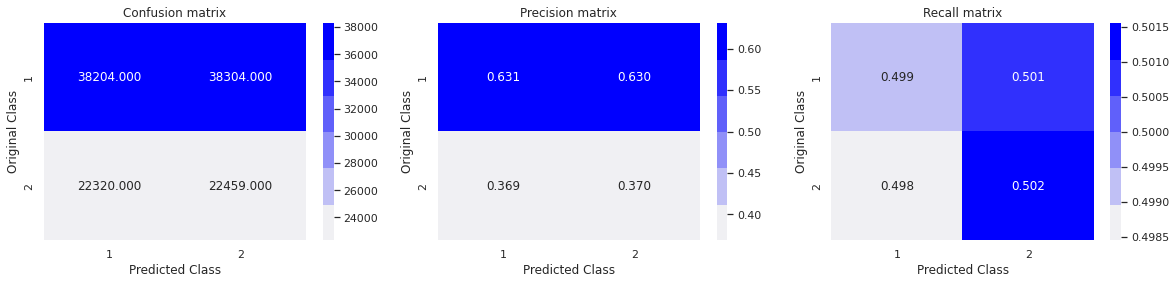

In [166]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

##  Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.5099278860776146
For values of alpha =  0.0001 The log loss is: 0.5033538631038262
For values of alpha =  0.001 The log loss is: 0.504837972504094
For values of alpha =  0.01 The log loss is: 0.5054513004385041
For values of alpha =  0.1 The log loss is: 0.5143551285649525
For values of alpha =  1 The log loss is: 0.5390720942264479
For values of alpha =  10 The log loss is: 0.5792925684962283


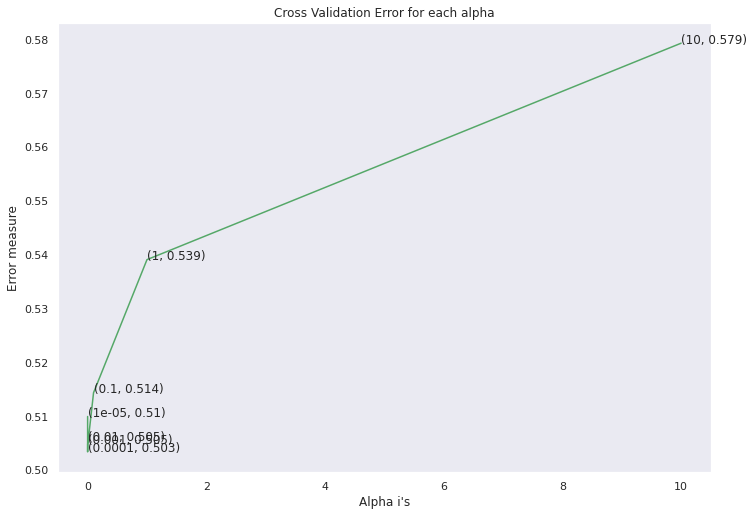

For values of best alpha =  0.0001 The train log loss is: 0.504587675976069
For values of best alpha =  0.0001 The test log loss is: 0.5033538631038262
Total number of data points : 121287


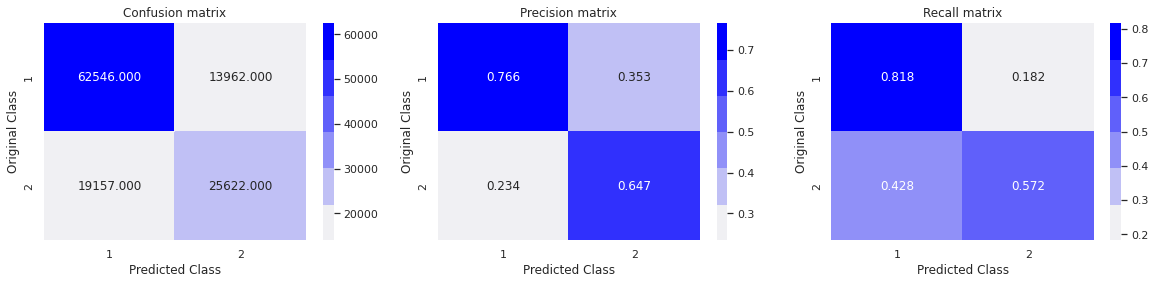

In [169]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.5099688136577365
For values of alpha =  0.0001 The log loss is: 0.505030446587818
For values of alpha =  0.001 The log loss is: 0.5093239116997594
For values of alpha =  0.01 The log loss is: 0.6138445071467573
For values of alpha =  0.1 The log loss is: 0.6177917818789026
For values of alpha =  1 The log loss is: 0.6585278256453734
For values of alpha =  10 The log loss is: 0.6585278256453736


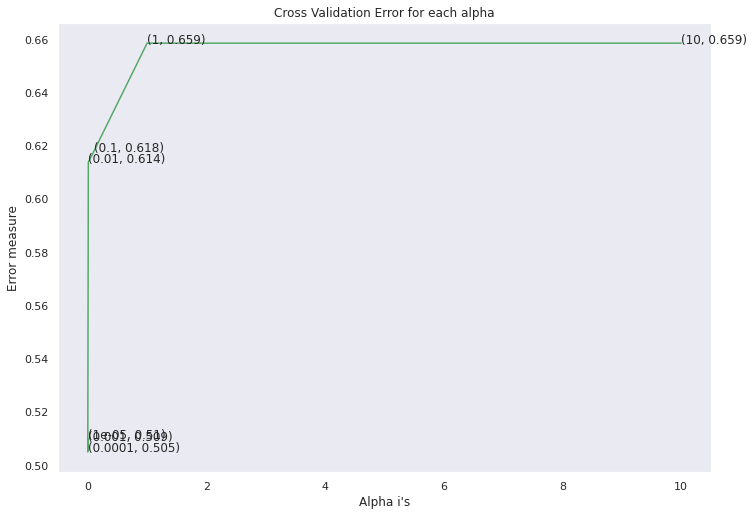

For values of best alpha =  0.0001 The train log loss is: 0.5055442496035211
For values of best alpha =  0.0001 The test log loss is: 0.505030446587818
Total number of data points : 121287


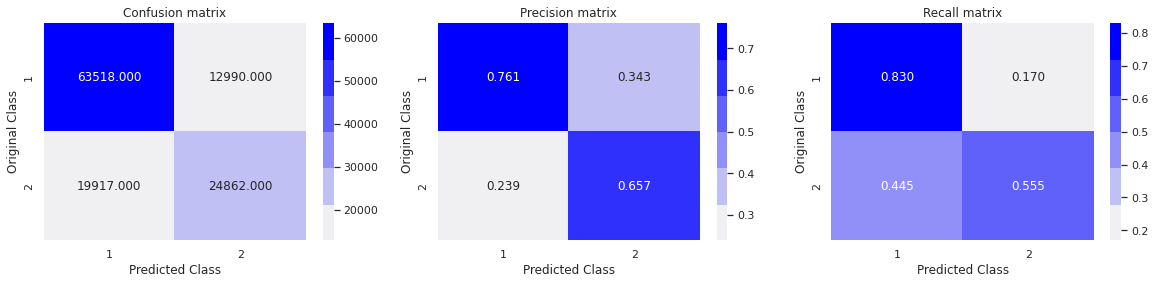

In [170]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)